## Trial Different Base Models

With the removal of the time-series model from the ensemble, we're down to just an `ExtraTreesRegressor` and Elo model feeding into an `ExtraTreesRegressor` meta-estimator. I suspect that adding a few more models to the ensemble would improve overall performance a bit, assuming that the new base estimators have decent performance (~70% mean accuracy across CV folds).

## Code Setup

In [4]:
%load_ext autoreload

In [25]:
%autoreload 2

import numpy as np
import pandas as pd
from mlxtend.regressor import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import (
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    VotingRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from augury.ml_estimators import StackingEstimator
from augury.ml_estimators.stacking_estimator import ELO_PIPELINE, META_PIPELINE
from augury.ml_estimators.base_ml_estimator import BASE_ML_PIPELINE
from augury.ml_data import MLData
from augury.settings import CV_YEAR_RANGE, SEED
from augury.model_tracking import score_model, graph_cv_model_performance
from augury.sklearn.preprocessing import DataFrameConverter

np.random.seed(SEED)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
data = MLData(train_year_range=(max(CV_YEAR_RANGE),))
data.data

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-02-15 08:29:25,794 - kedro.io.data_catalog - INFO - Loading data from `full_data` (JSONDataSet)...


team      oppo_team round_type  \
Adelaide         1991 1           Adelaide       Hawthorn    Regular   
                      2           Adelaide        Carlton    Regular   
                      3           Adelaide         Sydney    Regular   
                      4           Adelaide       Essendon    Regular   
                      5           Adelaide     West Coast    Regular   
...                                    ...            ...        ...   
Western Bulldogs 2021 19  Western Bulldogs       Adelaide    Regular   
                      20  Western Bulldogs      Melbourne    Regular   
                      21  Western Bulldogs       Essendon    Regular   
                      22  Western Bulldogs       Hawthorn    Regular   
                      23  Western Bulldogs  Port Adelaide    Regular   

                                   venue prev_match_oppo_team  \
Adelaide         1991 1    Football Park                    0   
                      2    Football Park             Hawthorn   
                      3           S.C.G.              Carlton   
                      4       Windy Hill               Sydney   
                      5          Subiaco             Essendon   
...                                  ...                  ...   
Western Bulldogs 2021 19  Eureka Stadium           Gold Coast   
                      20          M.C.G.             Adelaide   
                      21       Docklands            Melbourne   
                      22       York Park             Essendon   
                      23       Docklands             Hawthorn   

                         oppo_prev_match_oppo_team                      date  \
Adelaide         1991 1                  Melbourne 1991-03-22 03:56:00+00:00   
                      2                    Fitzroy 1991-03-31 03:56:00+00:00   
                      3                   Hawthorn 1991-04-07 03:05:00+00:00   
                      4            North Melbourne 1991-04-13 03:30:00+00:00   
                      5            North Melbourne 1991-04-21 05:27:00+00:00   
...                                            ...                       ...   
Western Bulldogs 2021 19                West Coast 2021-07-24 02:20:00+00:00   
                      20                Gold Coast 2021-07-31 02:20:00+00:00   
                      21                    Sydney 2021-08-07 02:20:00+00:00   
                      22               Collingwood 2021-08-14 02:11:00+00:00   
                      23                   Carlton 2021-08-21 02:20:00+00:00   

                          team_goals  team_behinds  score  ...  \
Adelaide         1991 1           24            11    155  ...   
                      2           12             9     81  ...   
                      3           19            18    132  ...   
                      4            6            11     47  ...   
                      5            9            11     65  ...   
...                              ...           ...    ...  ...   
Western Bulldogs 2021 19           0             0      0  ...   
                      20           0             0      0  ...   
                      21           0             0      0  ...   
                      22           0             0      0  ...   
                      23           0             0      0  ...   

                          oppo_rolling_prev_match_time_on_ground_skew  \
Adelaide         1991 1                                           0.0   
                      2                                           0.0   
                      3                                           0.0   
                      4                                           0.0   
                      5                                           0.0   
...                                                               ...   
Western Bulldogs 2021 19                                          0.0   
                      20                              

## Try different estimators

In [4]:
estimators = [
    XGBRegressor(random_state=SEED, verbose=False),
    CatBoostRegressor(random_seed=SEED),
    GradientBoostingRegressor(random_state=SEED),
    HistGradientBoostingRegressor(random_state=SEED),
    ExtraTreesRegressor(random_state=SEED),
    LinearSVR(),
    Ridge(),
    Lasso(),
    KNeighborsRegressor(),
    AdaBoostRegressor(random_state=SEED),
    SVR(kernel='rbf'),
]
estimator_scores = []

scores = score_model(ELO_PIPELINE, data, n_jobs=-1)
estimator_scores.append(scores)

for estimator in estimators:
    pipeline = make_pipeline(BASE_ML_PIPELINE, estimator)
    scores = score_model(pipeline, data, n_jobs=-1)
    estimator_scores.append(scores)

estimator_scores

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 co

[{'fit_time': array([1.27853966, 1.33495903, 1.18946385, 1.12688327, 1.043823  ]),
  'score_time': array([0.32906103, 0.33308363, 0.42092371, 0.48012614, 0.28849435]),
  'test_neg_mean_absolute_error': array([-37.91643124, -37.86807506, -32.15199695, -33.0790819 ,
         -29.98658654]),
  'test_match_accuracy': array([0.69902913, 0.71497585, 0.647343  , 0.71497585, 0.64251208])},
 {'fit_time': array([158.77840376, 169.34427738, 171.12495661, 170.36221123,
          22.02716303]),
  'score_time': array([0.36904788, 0.37150359, 0.21451402, 0.17691302, 0.07850599]),
  'test_neg_mean_absolute_error': array([-31.0534369 , -30.91602169, -31.01615917, -27.43429879,
         -28.30442699]),
  'test_match_accuracy': array([0.72815534, 0.69082126, 0.63285024, 0.71980676, 0.62318841])},
 {'fit_time': array([51.91288352, 57.30967569, 57.77953339, 58.67547083, 27.51634789]),
  'score_time': array([0.50475597, 0.20077229, 0.16583347, 0.12093234, 0.12364435]),
  'test_neg_mean_absolute_error': arra

In [5]:
results = []

for idx, scores in enumerate(estimator_scores):
    model_name = 'eloregressor' if idx == 0 else estimators[idx - 1].__class__.__name__.lower()
    results.append(
        {
            'model': model_name,
            'fit_time': scores['fit_time'].mean(),
            'match_accuracy': scores['test_match_accuracy'].mean(),
            'mae': abs(scores['test_neg_mean_absolute_error'].mean()),
        }
    )
    
results_df = pd.DataFrame(results)
results_df.sort_values('match_accuracy')

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,fit_time,match_accuracy,mae
9,kneighborsregressor,6.879164,0.661545,31.398248
10,adaboostregressor,31.586698,0.666376,29.573817
8,lasso,7.386410,0.676019,29.233265
1,xgbregressor,138.327402,0.678964,29.744869
0,eloregressor,1.194734,0.683767,34.200434
4,histgradientboostingregressor,388.231673,0.685723,28.439196
11,svr,245.423588,0.687623,29.018839
3,gradientboostingregressor,65.167974,0.689592,28.417348
6,linearsvr,8.442913,0.695375,28.530817
5,extratreesregressor,97.041817,0.695390,28.484511


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-02-14 21:55:49,596 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


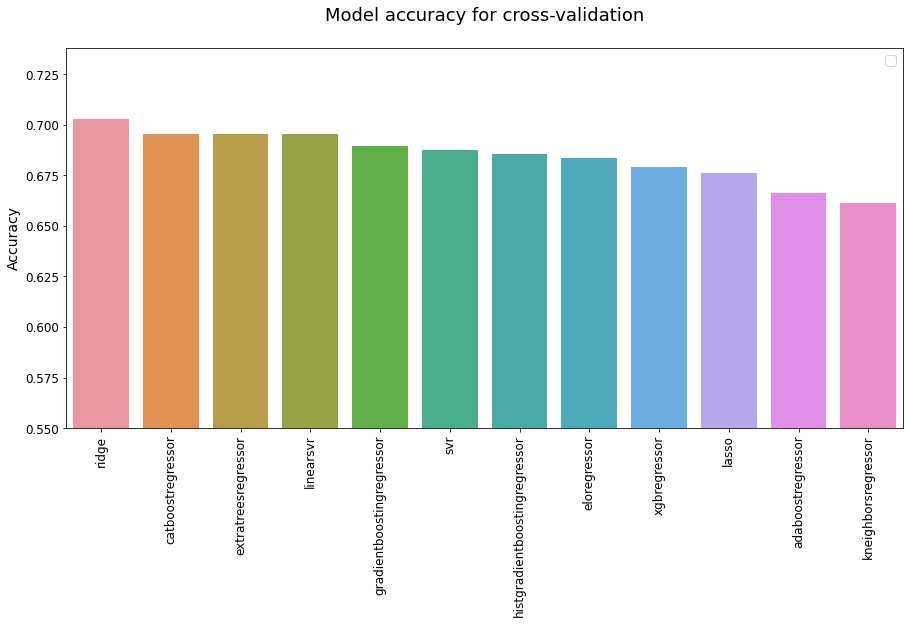

2021-02-14 21:55:49,902 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


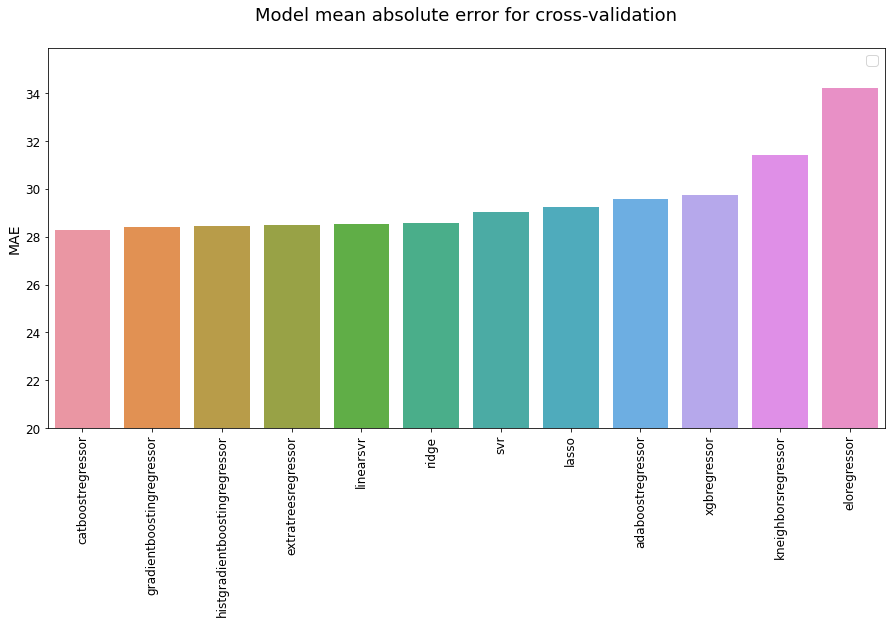

In [6]:
graph_cv_model_performance(results_df)

### Two estimators have higher accuracy than ExtraTreesRegressor, Seven higher than EloRegressor

Ridge and CatboostRegessor all got a higher accuracy than ExtraTreesRegressor, which is currently one of the base estimators in the ensemble. In addition to these, LinearSVR, GradientBoostingRegressor, SVR (with 'rbf' kernel), and HistGradientBoostingRegressor got higher accuracy than EloRegressor. To make sure that adding additional base estimators will actually improve overall performance, we'll measure accuracy after adding each one, starting with the best performing: Ridge.

## Add new estimators to stacking ensemble

In [26]:
top_estimators = [
    Ridge(),
    CatBoostRegressor(random_seed=SEED),
    LinearSVR(),
    GradientBoostingRegressor(random_state=SEED),
    SVR(kernel='rbf'),  
    ExtraTreesRegressor(random_state=SEED),
    HistGradientBoostingRegressor(random_state=SEED),
]
top_ensembles = []
regressors = []

for estimator in top_estimators:
    regressors.append(
        make_pipeline(
            DataFrameConverter(), BASE_ML_PIPELINE, estimator
        )
    )
    pipeline = StackingRegressor(
        regressors=[*regressors], meta_regressor=META_PIPELINE
    )
    top_ensembles.append(StackingEstimator(pipeline=pipeline))

# Append Elo estimator separately, because it requires a different pipeline from the others
regressors.append(ELO_PIPELINE)
pipeline = StackingRegressor(
    regressors=[*regressors], meta_regressor=META_PIPELINE
)
top_ensembles.append(StackingEstimator(pipeline=pipeline))

[(len(ensemble.pipeline.regressors), ensemble.pipeline.regressors[-1].steps[-1][0]) for ensemble in top_ensembles]

[(1, 'ridge'),
 (2, 'catboostregressor'),
 (3, 'linearsvr'),
 (4, 'gradientboostingregressor'),
 (5, 'svr'),
 (6, 'extratreesregressor'),
 (7, 'histgradientboostingregressor'),
 (8, 'eloregressor')]

In [80]:
ensemble_scores = []

for ensemble in top_ensembles:
    scores = score_model(ensemble, data, n_jobs=-1)
    ensemble_scores.append(scores)

ensemble_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too s

[{'fit_time': array([6.47730875, 6.61284995, 6.67107677, 6.79929113, 6.09728408]),
  'score_time': array([0.2807951 , 0.27366233, 0.23755908, 0.27848339, 0.23464632]),
  'test_neg_mean_absolute_error': array([-36.30861274, -35.02158139, -34.58206789, -30.79320129,
         -35.3605057 ]),
  'test_match_accuracy': array([0.68932039, 0.72463768, 0.65217391, 0.72463768, 0.60869565])},
 {'fit_time': array([71.54306149, 72.83449888, 73.52198648, 73.39540625, 30.64464617]),
  'score_time': array([0.33718157, 0.3210144 , 0.2883606 , 0.26059389, 0.2810452 ]),
  'test_neg_mean_absolute_error': array([-35.34884427, -32.78830328, -32.64849455, -32.70377626,
         -32.65424531]),
  'test_match_accuracy': array([0.68446602, 0.70048309, 0.65217391, 0.67149758, 0.59903382])},
 {'fit_time': array([78.35910606, 77.62702012, 79.57254457, 79.74348307, 35.81066561]),
  'score_time': array([0.36737037, 0.36650252, 0.31390285, 0.30758786, 0.30325079]),
  'test_neg_mean_absolute_error': array([-34.3303511

In [81]:
results = []

for idx, scores in enumerate(ensemble_scores):
    model_name = top_ensembles[idx].pipeline.regressors[-1].steps[-1][0]
    results.append(
        {
            'model': model_name,
            'fit_time': scores['fit_time'].mean(),
            'match_accuracy': scores['test_match_accuracy'].mean(),
            'mae': abs(scores['test_neg_mean_absolute_error'].mean()),
        }
    )
    
ensemble_results_df = pd.DataFrame(results)
ensemble_results_df

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,fit_time,match_accuracy,mae
0,ridge,6.531562,0.679893,34.413194
1,catboostregressor,64.387920,0.661531,33.228733
2,linearsvr,70.222564,0.668280,32.657369
3,gradientboostingregressor,127.539677,0.686680,32.220178
4,svr,331.483925,0.686666,31.944209
5,extratreesregressor,356.532049,0.701168,28.550522
6,histgradientboostingregressor,370.194848,0.701168,28.552771
7,eloregressor,407.977652,0.701168,28.552419


2021-02-15 03:57:32,529 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


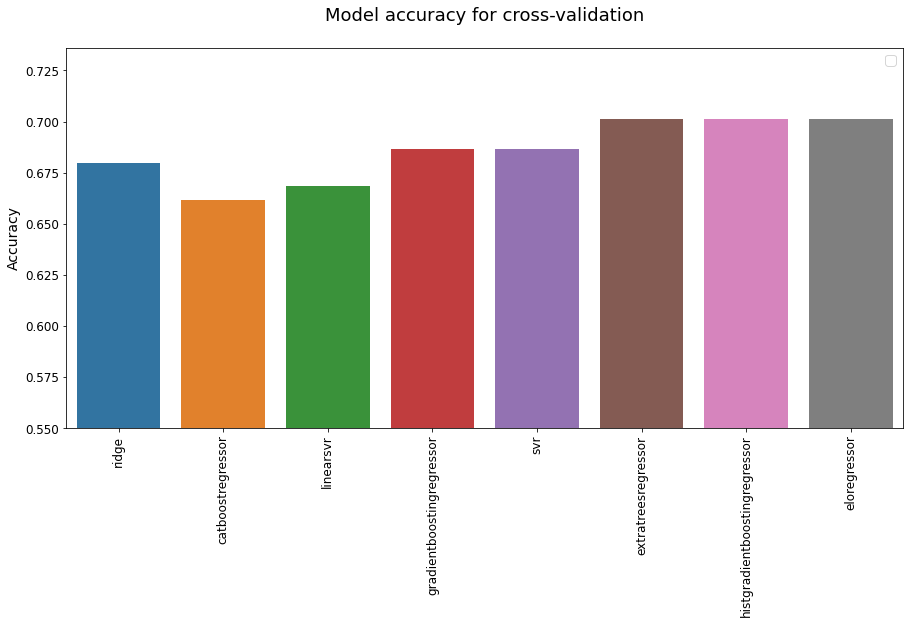

2021-02-15 03:57:32,897 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


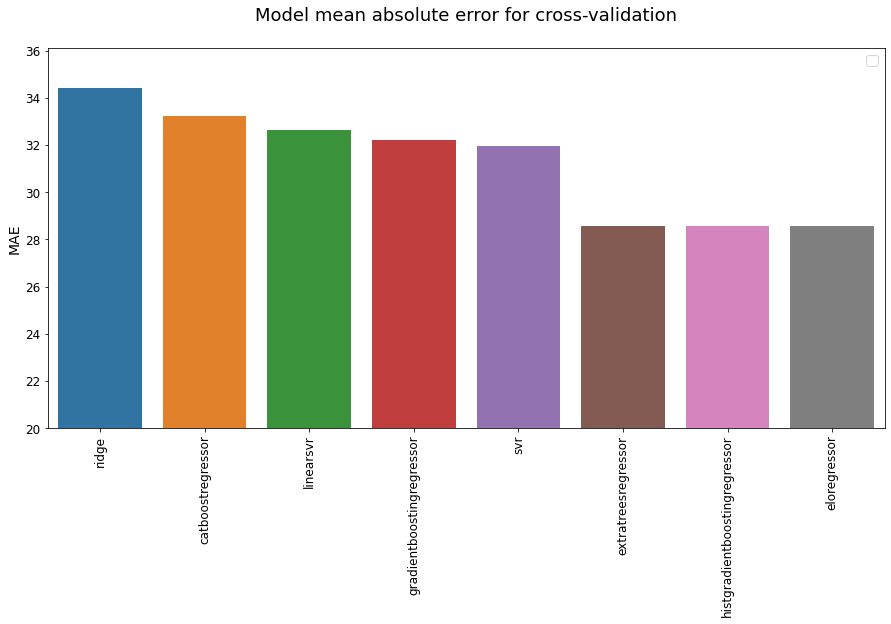

In [82]:
graph_cv_model_performance(ensemble_results_df, sort=False)

### Lone Ridge performs better than any stacking ensemble

As expected, the accuracy of the ensemble increased with more base estimators, until it tapered off as we reached a point of diminishing returns. However, the highest accuracy was still slightly lower than it was for a lone Ridge model, which is a little surprising. Perhaps `ExtraTreesRegressor` isn't well-suited to this new mix of base estimators.

## Try different meta-estimators

Taking the original mix of estimators used to find good base estimators for the stacking ensemble and using them as meta-estimators on top of the best-performing mix of base estimators from section 3.

In [29]:
meta_ensembles = []

base_estimators = [
    Ridge(),
    CatBoostRegressor(random_seed=SEED),
    LinearSVR(),
    GradientBoostingRegressor(random_state=SEED),
    SVR(kernel='rbf'),  
    ExtraTreesRegressor(random_state=SEED),
]
regressors = [
    make_pipeline(
        DataFrameConverter(), BASE_ML_PIPELINE, base_estimator
    ) for base_estimator in base_estimators
]
    
for meta_estimator in top_estimators:
    pipeline = StackingRegressor(
        regressors=[*regressors],
        meta_regressor=make_pipeline(
            StandardScaler(), meta_estimator
        )
    )
    meta_ensembles.append(StackingEstimator(pipeline=pipeline))

meta_ensembles.append(
    VotingRegressor(
        [(regressor.steps[-1][0], regressor) for regressor in regressors]
    )
)

[
    ensemble.pipeline.meta_regressor.steps[-1][0]
    for ensemble in meta_ensembles[:-1]
] + ['voting']

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['ridge',
 'catboostregressor',
 'linearsvr',
 'gradientboostingregressor',
 'svr',
 'extratreesregressor',
 'histgradientboostingregressor',
 'voting']

In [31]:
meta_scores = []

for ensemble in meta_ensembles:
    scores = score_model(ensemble, data, n_jobs=-1)
    meta_scores.append(scores)

meta_scores

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 co

[{'fit_time': array([522.64389515, 553.12044954, 567.9936285 , 588.03602934,
         367.22527528]),
  'score_time': array([ 8.04998636, 10.08305144,  7.11699605,  5.22632194,  5.40955114]),
  'test_neg_mean_absolute_error': array([-30.47798111, -29.20153787, -28.05378873, -26.19498761,
         -27.93605031]),
  'test_match_accuracy': array([0.7184466 , 0.73429952, 0.67149758, 0.7294686 , 0.65217391])},
 {'fit_time': array([476.90565968, 510.49309778, 528.43991971, 543.55589628,
         383.36963463]),
  'score_time': array([ 6.29383063, 11.92398357,  7.06984067,  6.34693289,  5.0892899 ]),
  'test_neg_mean_absolute_error': array([-30.50565733, -29.22078046, -28.04139136, -26.21248429,
         -27.93377829]),
  'test_match_accuracy': array([0.71359223, 0.73913043, 0.67149758, 0.72463768, 0.65700483])},
 {'fit_time': array([468.15937638, 487.91700864, 509.21703959, 521.31605601,
         358.08889723]),
  'score_time': array([6.50025272, 8.36914062, 7.72844625, 5.71874452, 4.9954712

In [37]:
results = []

for idx, scores in enumerate(meta_scores):
    model_name = meta_ensembles[idx].pipeline.meta_regressor.steps[-1][0] if idx < len(meta_scores) - 1 else 'voting'
    results.append(
        {
            'model': model_name,
            'fit_time': scores['fit_time'].mean(),
            'match_accuracy': scores['test_match_accuracy'].mean(),
            'mae': abs(scores['test_neg_mean_absolute_error'].mean()),
        }
    )
    
meta_results_df = pd.DataFrame(results)
meta_results_df

,model,fit_time,match_accuracy,mae
0,ridge,519.803856,0.701177,28.372869
1,catboostregressor,488.552842,0.701173,28.382818
2,linearsvr,468.939676,0.701177,28.373298
3,gradientboostingregressor,475.887823,0.699245,28.378574
4,svr,433.075113,0.698274,28.422192
5,extratreesregressor,411.976378,0.700211,28.370611
6,histgradientboostingregressor,376.510702,0.699245,28.381481
7,voting,468.602414,0.700220,28.166399


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-02-16 00:49:23,779 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


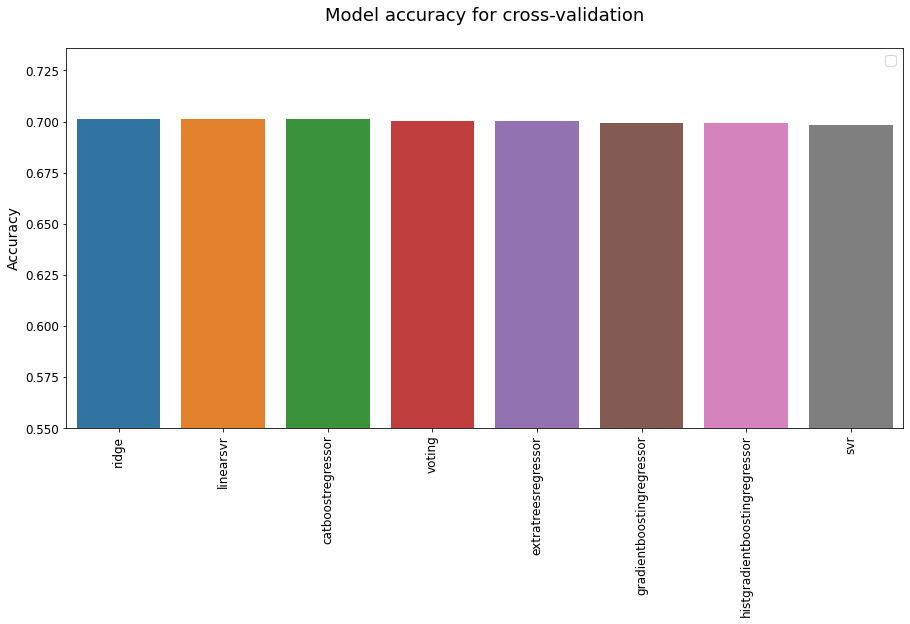

2021-02-16 00:49:24,632 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


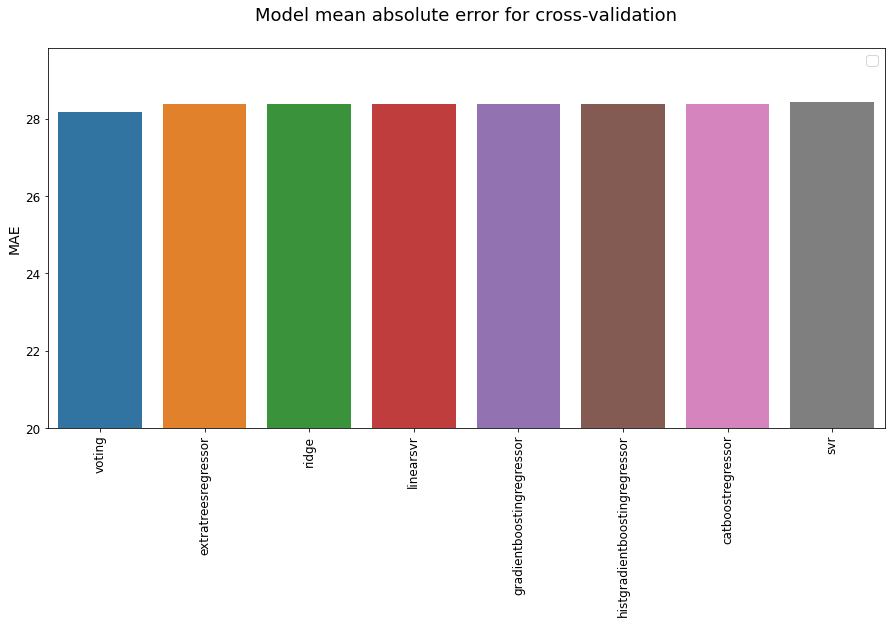

In [38]:
graph_cv_model_performance(meta_results_df)

## Conclusion

I guess with the reduced data set, a plain `Ridge` model is more accurate than the variety of ensembles that I tested. I was curious if it maybe just had one or two _really_ good years in the CV range that increased its mean accuracy, while ensembles were a bit more consistent, but it seems that all models were bad in 2017 and 2019 and better in the other years, so `Ridge` is just more accurate.

It's possible that with param tuning, some of the gradient-boosted tree models would surpass `Ridge`, as there are more dials to turn, but I doubt the difference would be significant enough to make it worth the trouble.